In [34]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os

In [35]:
# Define image size and directories
IMAGE_SIZE = [224, 224]
train_directory = r"C:\Users\castr\OneDrive\Desktop\Image Classification\dataset\train"
test_directory = r"C:\Users\castr\OneDrive\Desktop\Image Classification\dataset\test"
val_directory = r"C:\Users\castr\OneDrive\Desktop\Image Classification\dataset\val"

In [36]:
# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [37]:
# Data augmentation for testing set (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

In [38]:
# Load training and testing sets with data augmentation
training_set = train_datagen.flow_from_directory(
    train_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_set = test_datagen.flow_from_directory(
    test_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 2770 images belonging to 10 classes.
Found 1377 images belonging to 10 classes.


In [39]:
# Add preprocessing layer to the front of DenseNet121
densenet = DenseNet121(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

In [40]:
# Freeze the layers
for layer in densenet.layers:
    layer.trainable = False
    
# Global Average Pooling
x = GlobalAveragePooling2D()(densenet.output)

# Fully Connected Layer
x = Dense(128, activation='relu')(x)

# Output Layer
output_tensor = Dense(10, activation='softmax')(x)

# Create the model
model = Model(inputs=densenet.input, outputs=output_tensor)


In [41]:
# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [58]:
# Train the model
history = model.fit(
    training_set,
    validation_data=test_set,
    epochs=10,
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set)
)

Epoch 1/10
87/87 [==============================] - 141s 2s/step - loss: 0.8961 - accuracy: 0.7105 - val_loss: 0.4181 - val_accuracy: 0.8751
Epoch 2/10
87/87 [==============================] - 131s 2s/step - loss: 0.3748 - accuracy: 0.8809 - val_loss: 0.2713 - val_accuracy: 0.9208
Epoch 3/10
87/87 [==============================] - 139s 2s/step - loss: 0.2718 - accuracy: 0.9209 - val_loss: 0.2321 - val_accuracy: 0.9346
Epoch 4/10
87/87 [==============================] - 133s 2s/step - loss: 0.2270 - accuracy: 0.9375 - val_loss: 0.2050 - val_accuracy: 0.9448
Epoch 5/10
87/87 [==============================] - 130s 1s/step - loss: 0.2035 - accuracy: 0.9404 - val_loss: 0.1897 - val_accuracy: 0.9441
Epoch 6/10
87/87 [==============================] - 130s 1s/step - loss: 0.1662 - accuracy: 0.9437 - val_loss: 0.1764 - val_accuracy: 0.9441
Epoch 7/10
87/87 [==============================] - 130s 1s/step - loss: 0.1718 - accuracy: 0.9484 - val_loss: 0.1983 - val_accuracy: 0.9463
Epoch 8/10
87

In [59]:
# Save the model
model.save('bird_species_densenet121.h5')

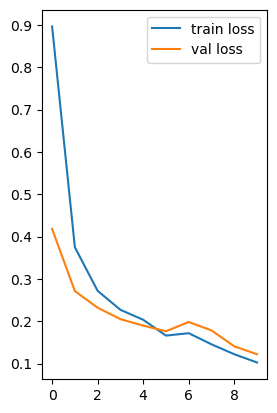

In [60]:
# Plot loss and accuracy curves
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()

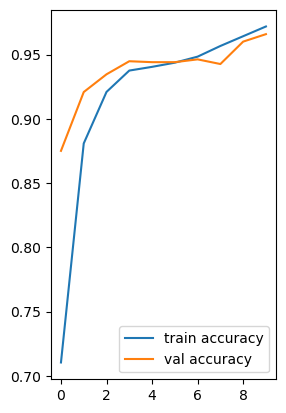

In [61]:
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()

In [62]:
from tensorflow.keras.applications import DenseNet121

In [63]:
# Load the saved model using DenseNet121
saved_model_path = 'bird_species_densenet121.h5'
loaded_model = load_model(saved_model_path, compile=False)

In [64]:
# Define the labels
labels = {
    0: 'Crowned Pigeon',
    1: 'Green Imperial-Pigeon',
    2: 'Island Thrush',
    3: 'Philippine Coucal',
    4: 'Philippine Cuckoo-Dove',
    5: 'Philippine Eagle',
    6: 'Philippine Hawk-Eagle',
    7: 'Philippine Serpent Eagle',
    8: 'Philippine Turtle Dove',
    9: 'Philippine Wood Pigeon',
}

In [65]:
# Define the output function
def output(location, model, label_mapping):
    img = load_img(location, target_size=(224, 224))  # Adjust target size for DenseNet121
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)

    predicted_class = np.argmax(prediction, axis=-1)
    predicted_probability = prediction[0, predicted_class[0]]
    
    if predicted_class[0] in label_mapping:
        class_label = label_mapping[predicted_class[0]]
        return class_label, predicted_probability
    else:
        return "Unknown Class (Index: {})".format(predicted_class[0]), predicted_probability


1/1 [==============================] - 2s 2s/step
Bird Species Prediction: Crowned Pigeon
Predicted Probability: 0.9994313


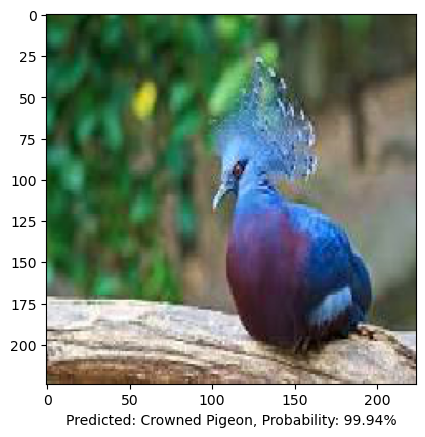

In [66]:
# Test the model on a new image
img_path = r"C:\Users\castr\OneDrive\Desktop\Image Classification\dataset\train\Crowned Pigeon\5.jpg"
pic = load_img(img_path, target_size=(224, 224))  # Adjust target size for DenseNet121
plt.imshow(pic)
result, predicted_probability = output(img_path, loaded_model, labels)
print("Bird Species Prediction:", result)
print("Predicted Probability:", predicted_probability)

# Add label to the plot
plt.xlabel(f"Predicted: {result}, Probability: {predicted_probability:.2%}")
plt.show()